Today I wanted to try my hand at a kaggle [competition](https://www.kaggle.com/c/humpback-whale-identification) that seemed like another great place to practice using image neural networks. The competition asks us to identify humpback whales from their flukes (tail fins). Before getting into the model training, however, it's always important to **look at your data**. So let's do some basic exploratory data analysis (EDA) to better inform ourselves on just what our model will be looking at and attempting to train on.

# Basic data exploration:

1. distribution of images per whale
1. viewing some images (same whale, different whale, 'new_whale')
1. distribution of image resolution between train & test
1. duplicate image analysis by perceptual hash

In [2]:
# used ideas from:
# https://www.kaggle.com/mmrosenb/whales-an-exploration 
# https://www.kaggle.com/stehai/duplicate-images
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 9]

import collections
from PIL import Image

DIR = "../input"

train = pd.read_csv(os.path.join(DIR, "train.csv"))
test = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))

In [4]:
train.shape, test.shape

((25361, 2), (7960, 2))

In [5]:
train.head()

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale

## Distribution of images per whale is highly skewed.

1. 2000+ whales have just one (!!!) image
2. Single whale with most images have 73 of them
3. Images dsitribution:
  1. almost 30% comes from whales with 4 or less images
  1. almost 40% comes from 'new_whale' group (!!!)
  1. the rest 30% comes from whales with 5-73 images


Let's look at how I figured out the above points. First let's look at the most populous whales in the dataset:

In [7]:
train['Id'].value_counts()[:4]

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
Name: Id, dtype: int64

So this ```new_whale``` distinction appears to take up quite a bit of the dataset! Let's now see how many image per whale we can expect.

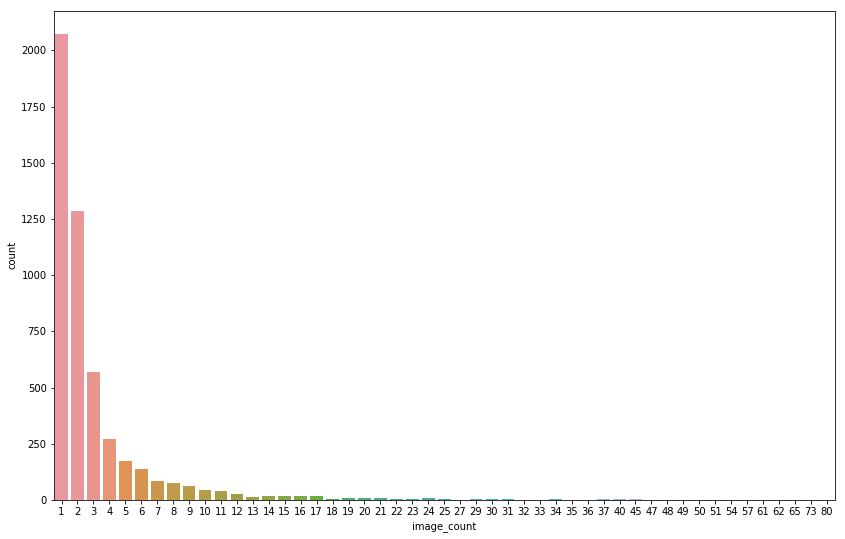

In [8]:
counted = train.groupby("Id").count().rename(columns={"Image":"image_count"})
counted.loc[counted["image_count"] > 80,'image_count'] = 80
plt.figure()
sns.countplot(data=counted, x="image_count")
plt.show()

So it appears that a lot of the whales only have a few example images in the training set. Lets look at the cumulative totals to get an idea of the distribution.

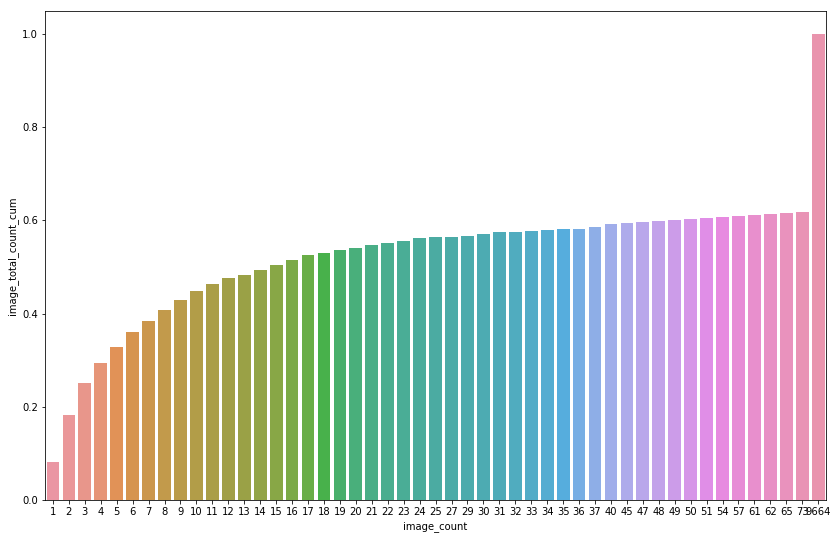

In [8]:
image_count_for_whale = train.groupby("Id", as_index=False).count().rename(columns={"Image":"image_count"})
whale_count_for_image_count = image_count_for_whale.groupby("image_count", as_index=False).count().rename(columns={"Id":"whale_count"})
whale_count_for_image_count['image_total_count'] = whale_count_for_image_count['image_count'] * whale_count_for_image_count['whale_count']
whale_count_for_image_count['image_total_count_cum'] = whale_count_for_image_count["image_total_count"].cumsum() / len(train)
sns.barplot(x='image_count',y='image_total_count_cum',data=whale_count_for_image_count)

In [9]:
whale_count_for_image_count[:10]

image_count  whale_count  image_total_count  image_total_count_cum
0            1         2073               2073               0.081740
1            2         1285               2570               0.183076
2            3          568               1704               0.250266
3            4          273               1092               0.293324
4            5          172                860               0.327235
5            6          136                816               0.359410
6            7           86                602               0.383147
7            8           76                608               0.407121
8            9           62                558               0.429123
9           10           46                460               0.447262

In [10]:
whale_count_for_image_count[-3:]

image_count  whale_count  image_total_count  image_total_count_cum
46           65            1                 65               0.616064
47           73            1                 73               0.618942
48         9664            1               9664               1.000000

A few thoughts:
1. 'Typical' CNNs (e.g. resnet) are going to have difficulty learning from only 1-4 examples of each whale. This implies that we might want to try an alternative architecture for this task. One-shot learning seems to be related to this, I'll look into this further.
2. The ```new_whale``` category takes up over 40% of our training data. Will be interesting to see whether our model will have anyting to gain from these unknown whales or whether it would benefit us to just cut them from the dataset.

# Let's see some images
1. There are a wide range of images in the dataset. Large variety in color, colormaps (RGB vs black/white), image size and orientation of the image. Would greatly benefit from some standardization.
2. Looking at different images of one specific whale makes it seem like identification would be possible as they appear quite unique

#### Some images of 'new_whale'

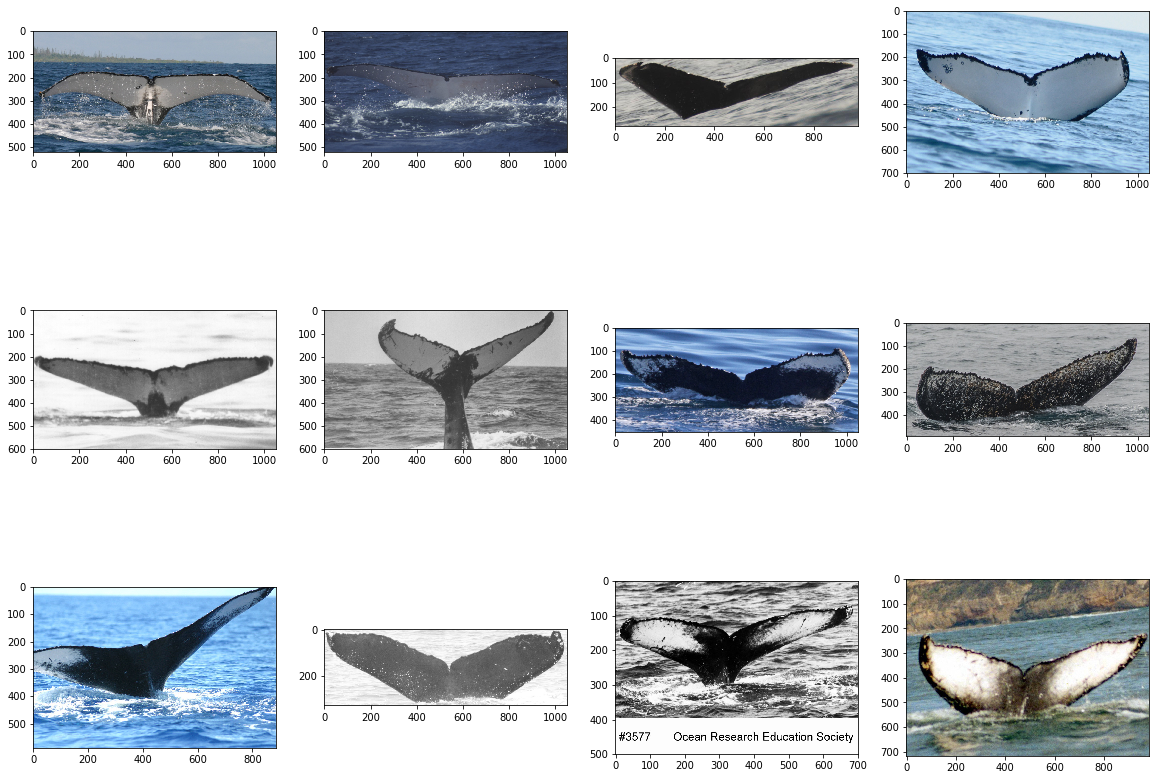

In [11]:
fig = plt.figure(figsize = (20, 15))
for idx, img_name in enumerate(train[train['Id'] == 'new_whale']['Image'][:12]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(DIR,"train",img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

plt.show()

#### Now some pictures of whales that have just 1 image: quite a large variance in colors

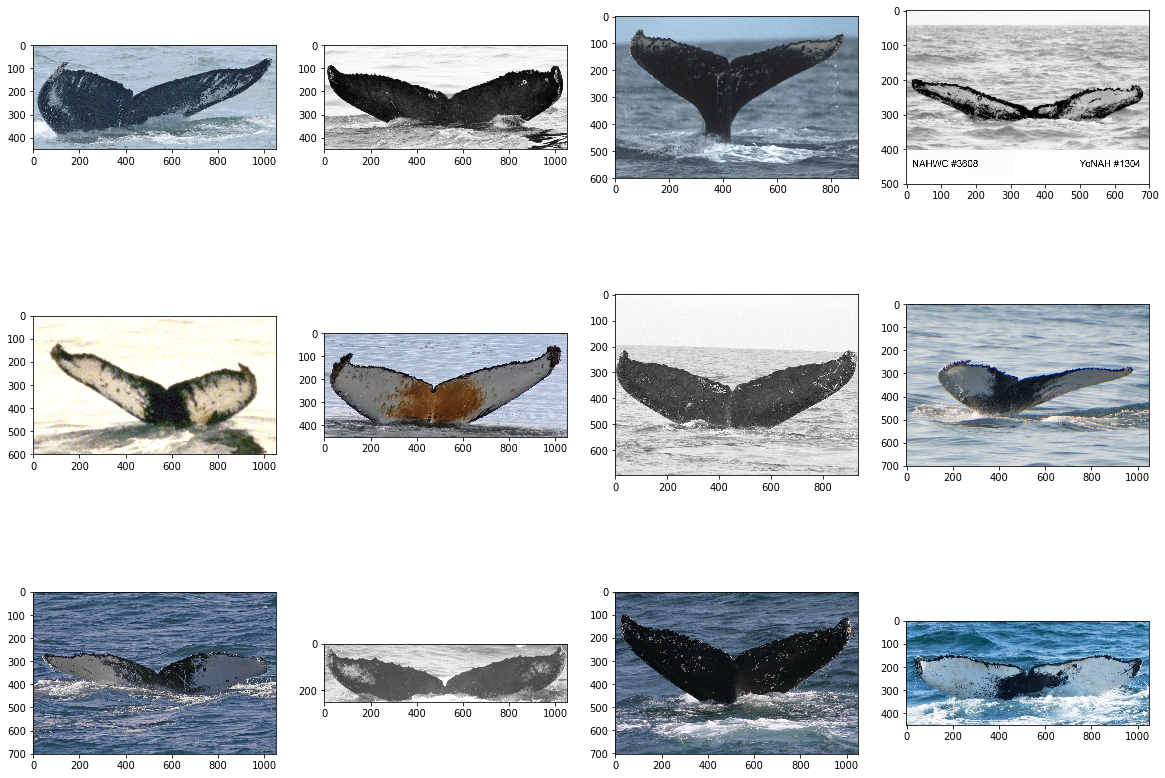

In [12]:
single_whales = train['Id'].value_counts().index[-12:]
fig = plt.figure(figsize = (20, 15))

for widx, whale in enumerate(single_whales):
    for idx, img_name in enumerate(train[train['Id'] == whale]['Image'][:1]):
        axes = widx + idx + 1
        y = fig.add_subplot(3, 4, axes)
        img = cv2.imread(os.path.join(DIR,"train",img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        y.imshow(img)

plt.show()

#### Below: each row shows pictures of one whale. I think it's quite easy to at least see similiar appearence there

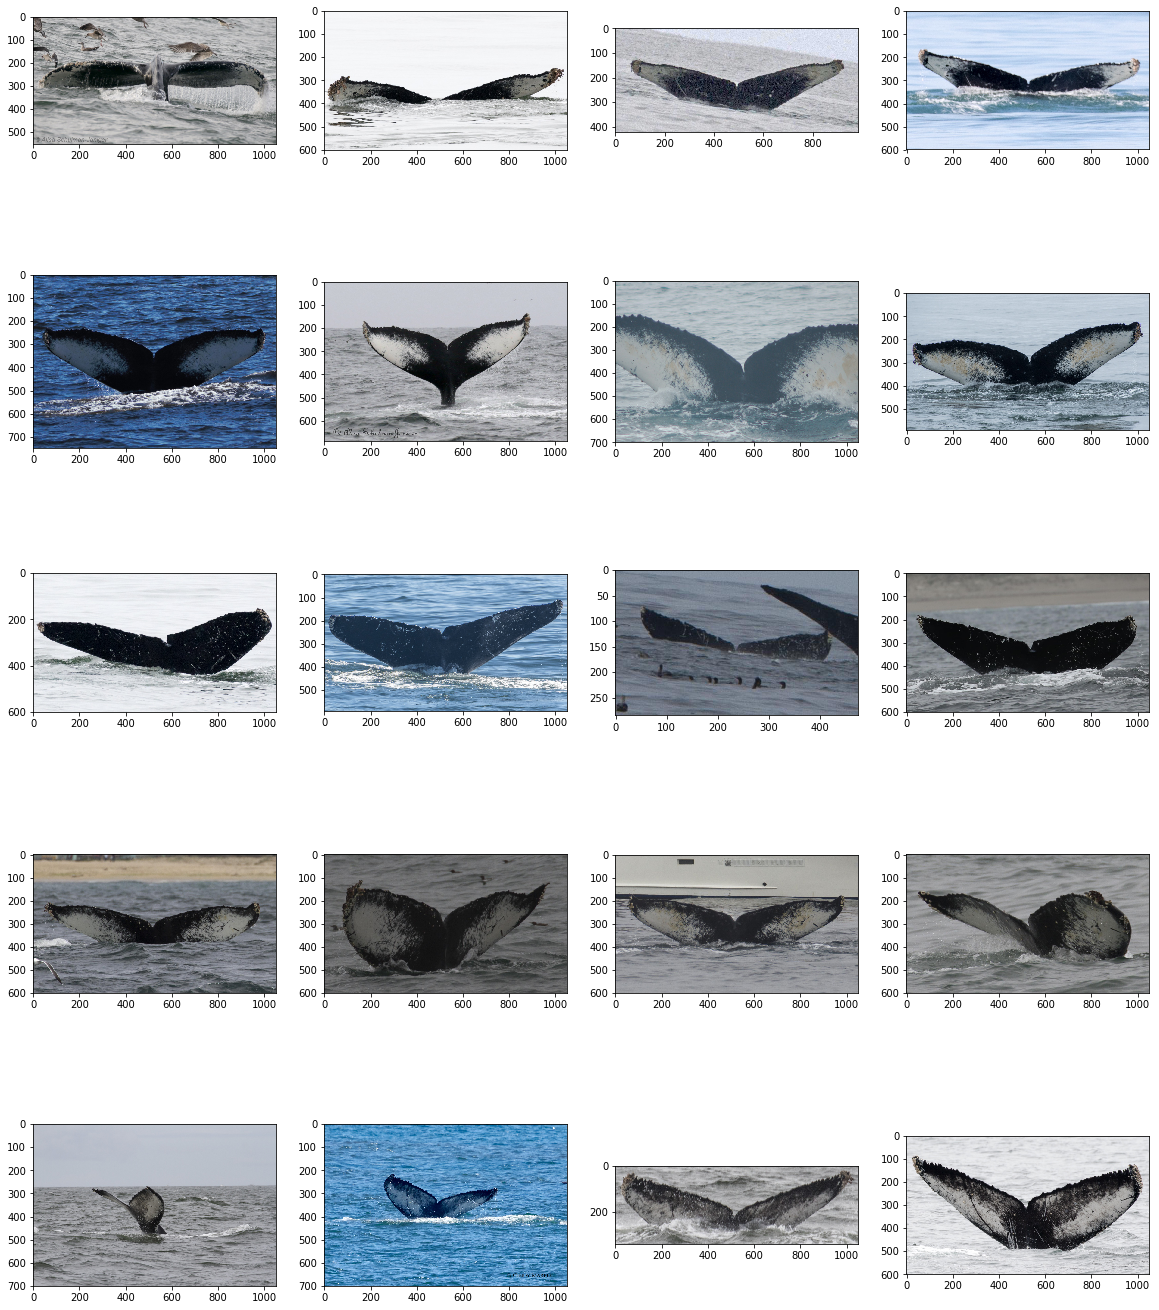

In [13]:
topN=5
top_whales = train['Id'].value_counts().index[1:1+topN]
fig = plt.figure(figsize = (20, 5*topN))

for widx, whale in enumerate(top_whales):
    for idx, img_name in enumerate(train[train['Id'] == whale]['Image'][:4]):
        axes = widx*4 + idx+1
        y = fig.add_subplot(topN, 4, axes)
        img = cv2.imread(os.path.join(DIR,"train",img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        y.imshow(img)

plt.show()

# Resolutions

over 7000 unique resolutions but 39 most popular cover ~45% images (both in train and in test)

In [16]:
imageSizes_train = collections.Counter([Image.open(f'{DIR}/train/{filename}').size
                        for filename in os.listdir(f"{DIR}/train")])
imageSizes_test = collections.Counter([Image.open(f'{DIR}/test/{filename}').size
                        for filename in os.listdir(f"{DIR}/test")])

In [17]:
def isdf(imageSizes):
    imageSizeFrame = pd.DataFrame(list(imageSizes.most_common()),columns = ["imageDim","count"])
    imageSizeFrame['fraction'] = imageSizeFrame['count'] / sum(imageSizes.values())
    imageSizeFrame['count_cum'] = imageSizeFrame['count'].cumsum()
    imageSizeFrame['count_cum_fraction'] = imageSizeFrame['count_cum'] / sum(imageSizes.values())
    return imageSizeFrame

train_isdf = isdf(imageSizes_train)
train_isdf['set'] = 'train'
test_isdf = isdf(imageSizes_test)
test_isdf['set'] = 'test'

In [18]:
isizes = train_isdf.merge(test_isdf, how="outer", on="imageDim")
isizes['total_count'] = isizes['count_x'] + isizes['count_y']
dims_order = isizes.sort_values('total_count', ascending=False)[['imageDim']]
len(dims_order)

7053

In [19]:
isizes = pd.concat([train_isdf, test_isdf])

In [20]:
isizes.shape

(8150, 6)

In [21]:
isizes.head()

imageDim  count  fraction  count_cum  count_cum_fraction    set
0  (1050, 700)   3330  0.131304       3330            0.131304  train
1  (1050, 600)   2549  0.100509       5879            0.231813  train
2  (1050, 450)   1556  0.061354       7435            0.293167  train
3  (1050, 525)   1303  0.051378       8738            0.344545  train
4   (700, 500)    667  0.026300       9405            0.370845  train

In [22]:
popularSizes = isizes[isizes['fraction'] > 0.002]
popularSizes.shape

(39, 6)

In [23]:
popularSizes.groupby('set').max()['count_cum_fraction']

set
test     0.456030
train    0.445803
Name: count_cum_fraction, dtype: float64

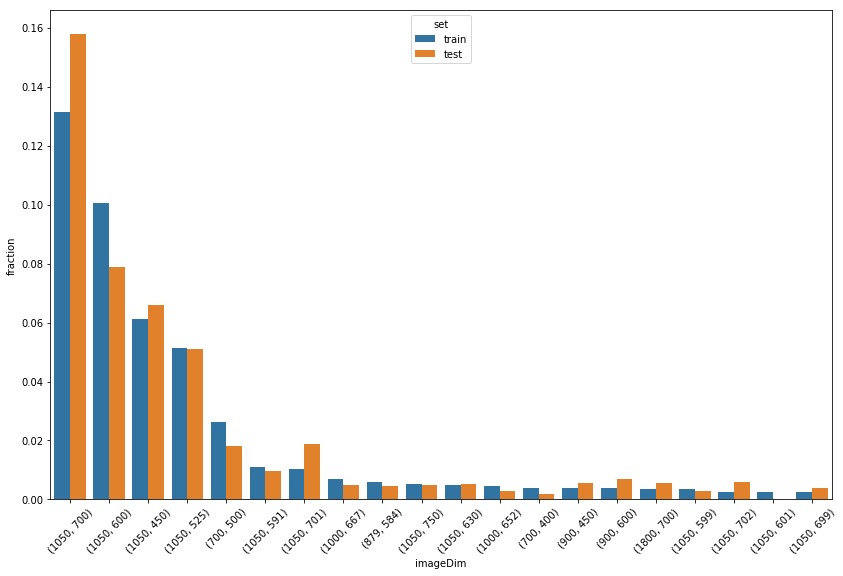

In [24]:
sns.barplot(x='imageDim',y='fraction',data = popularSizes, hue="set")
_ = plt.xticks(rotation=45)

# Duplicates

1. Found duplicates using imagehash. Great introduction [here](https://realpython.com/fingerprinting-images-for-near-duplicate-detection/)
1. 1 duplicate in train set
1. 3 duplicates between train and test
1. totally different than in playground dataset: 
  1. [playground duplicates](https://www.kaggle.com/stehai/duplicate-images)
  1. [solution that used duplicate information](https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563)


In [10]:
import imagehash

def getImageMetaData(file_path):
    with Image.open(file_path) as img:
        img_hash = imagehash.phash(img)
        return img.size, img.mode, img_hash

def get_img_duplicates_info(df, dataset):
    
    m = df.Image.apply(lambda x: getImageMetaData(os.path.join(DIR, dataset, x)))
    df["Hash"] = [str(i[2]) for i in m]
    df["Shape"] = [i[0] for i in m]
    df["Mode"] = [str(i[1]) for i in m]
    df["Length"] = df["Shape"].apply(lambda x: x[0]*x[1])
    df["Ratio"] = df["Shape"].apply(lambda x: x[0]/x[1])
    df["New_Whale"] = df.Id == "new_whale"
    
    
    img_counts = df.Id.value_counts().to_dict()
    df["Id_Count"] = df.Id.apply(lambda x: img_counts[x])
    return df

In [11]:
train_dups = get_img_duplicates_info(train, "train")

In [12]:
train_dups.head()

Image         Id              Hash        Shape Mode  Length  \
0  0000e88ab.jpg  w_f48451c  d26698c3271c757c  (1050, 700)  RGB  735000   
1  0001f9222.jpg  w_c3d896a  ba8cc231ad489b77   (758, 325)  RGB  246350   
2  00029d126.jpg  w_20df2c5  bbcad234a52d0f0b  (1050, 497)  RGB  521850   
3  00050a15a.jpg  new_whale  c09ae7dc09f33a29  (1050, 525)  RGB  551250   
4  0005c1ef8.jpg  new_whale  d02f65ba9f74a08a  (1050, 525)  RGB  551250   

      Ratio  New_Whale  Id_Count  
0  1.500000      False        14  
1  2.332308      False         4  
2  2.112676      False         4  
3  2.000000       True      9664  
4  2.000000       True      9664

In [13]:
t = train_dups.Hash.value_counts()
t = t.loc[t>1]

In [14]:
"Duplicate hashes: {}".format(len(t))

'Duplicate hashes: 1'

In [15]:
t

94216bb289ccd63f    2
Name: Hash, dtype: int64

In [16]:
t.index[0]

'94216bb289ccd63f'

In [17]:
train_dups[train_dups['Hash'] == t.index[0]].head()

Image         Id              Hash        Shape Mode  Length  \
9542   60a3f2422.jpg  w_7a8ce16  94216bb289ccd63f  (1050, 525)  RGB  551250   
12618  7f7a63b8a.jpg  w_7a8ce16  94216bb289ccd63f  (1050, 525)  RGB  551250   

       Ratio  New_Whale  Id_Count  
9542     2.0      False         6  
12618    2.0      False         6

#### The only duplicate found in train dataset comes from the same whale.


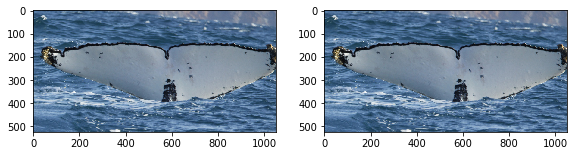

In [18]:
fig = plt.figure(figsize = (20, 10))
for idx, img_name in enumerate(train_dups[train_dups['Hash'] == t.index[0]]['Image'][:2]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(DIR,"train",img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

plt.show()

In [19]:
test_dups = get_img_duplicates_info(test, "test")

In [20]:
test_d = test_dups.Hash.value_counts()
test_d = test_d.loc[test_d>1]
"Duplicate hashes in test: {}".format(len(test_d))

'Duplicate hashes in test: 0'

In [21]:
common_hashes = test_dups.merge(train_dups, how="inner", on="Hash", suffixes=("_test","_train"))
common_hashes.head()

Image_test                                            Id_test  \
0  d37179fd1.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c   
1  f50529c53.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c   
2  fb3879dc7.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c   

               Hash   Shape_test Mode_test  Length_test  Ratio_test  \
0  eecad0b52d4ac2f0  (1050, 700)       RGB       735000    1.500000   
1  afdac0b52a5a82b5  (1050, 690)       RGB       724500    1.521739   
2  ad4ac2b43d0fcaf0  (1050, 700)       RGB       735000    1.500000   

   New_Whale_test  Id_Count_test    Image_train   Id_train  Shape_train  \
0           False           7960  01f66ca26.jpg  new_whale  (1000, 667)   
1           False           7960  579886448.jpg  new_whale  (1050, 690)   
2           False           7960  b95d73a55.jpg  w_691f2f6  (1000, 667)   

  Mode_train  Length_train  Ratio_train  New_Whale_train  Id_Count_train  
0        RGB        667000     1.499250             True            9664  
1        RGB        724500     1.521739             True            9664  
2        RGB        667000     1.499250            False               8

In [22]:
"Duplicate hashes between train and test: {}".format(len(common_hashes))

'Duplicate hashes between train and test: 3'

### below each row shows images with the same pHash, left column from train, right from test

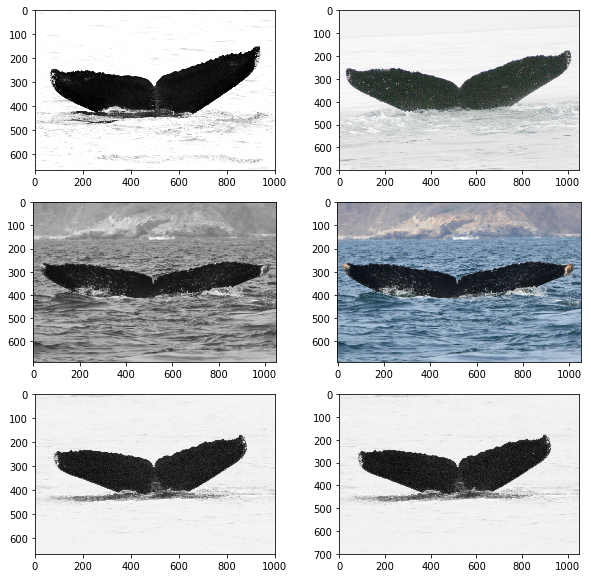

In [23]:
fig = plt.figure(figsize = (10, 10))

for idx, images in enumerate(common_hashes[['Image_train','Image_test']].values):
    y = fig.add_subplot(len(common_hashes),2, idx*2+1)
    img = cv2.imread(os.path.join(DIR,"train",images[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

    y = fig.add_subplot(len(common_hashes),2, idx*2+2)
    img = cv2.imread(os.path.join(DIR,"test",images[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

    
plt.show()

In [24]:
# train duplicates - to remove:
train_to_remove = train_dups[train_dups['Hash'] == t.index[0]].drop_duplicates('Hash')[['Image']]
train_to_remove.to_csv("train_remove.csv",index=False)
train_to_remove.head()

Image
9542  60a3f2422.jpg

In [25]:
# easy answers in test:
easy_peasy = common_hashes[['Image_test','Id_train']]
easy_peasy.to_csv("test_easy.csv", index=False)
easy_peasy.head()

Image_test   Id_train
0  d37179fd1.jpg  new_whale
1  f50529c53.jpg  new_whale
2  fb3879dc7.jpg  w_691f2f6

# Conclusion

Just by poking around the dataset I've gained quite a bit of insight on how we're going to tackle this problem. My next step is going to be cleaning and standardizing the dataset, to make it easier to train on. Then, I'll need to find an architecture that is the best suited for learning off of very few examples. I'm not sure if such an architecture exists but I'll report back with what I find!